# TIAFI algorithm

[TIAFI's](https://tiafi.org/) support algorithm aims to help an NGO supporting Syrian refugees in Izmir, Turkey to fairly and efficiently distribute 250 monthly food packages and 150 monthly hygiene packages among its thousands of service members. This notebook outlines how the eligibility score is calculated, shows how tuning the algorithm's time weight affects the resulting distribution and optimises the time weight based on the desired distribution.

## Algorithm

$$
S_{𝑖} = \frac{Z_{F𝑖}W_{F} + Z_{V𝑖}W_{V} + Z_{T𝑖}W_{T}}{n}
$$

<br/>

Where... 
* S = score 
* 𝑖 = imaginary unit (1, 2, 3, 4... 𝑖)
* Z = the z-score (deviance from the mean in standard deviations) of a given variable
* W = the weight a given variable is multiplied by
* F = financial situation (in Turkish Lira per family member on a monthly basis)
* V = vulnerability (from a minimum of 1 to a maximum of 3)
* T = time since last recieving a package (in days with an unknown default of 365)
* n = the number of variables included (in this case 3)


<br/>

<details>
<summary>Full version ▼</summary>

$$
S_{𝑖} = \frac{ \frac{F_{𝑖}-μ_{F} }{σ_{F} }W_{F} + \frac{V_{𝑖}-μ_{V} }{σ_{V} }W_{V} + \frac{T_{𝑖}-μ_{T} }{σ_{T} }W_{T} }{n}
$$
      
* μ = the mean of a given variable  
* σ = the standard deviation (how far the average value deviates from the mean) of a given variable
    
</details>
<br/>

## Tuning

The tuning process experiments with different weights to find the percentage of people who would recieve a package at least once, the max number of times any single person would recieve it and how many people would recieve it the max number of times over an n month period.

<br/>

## Import data

Imports the packages, defines the options and reads in the dataframes.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# loads the initial data frame (based on the roughly 1,000 members already signed up to the support scheme)
initial_data = pd.read_csv('C:/Users/HUAWEI/Desktop/TIAFI/Distribution list/Algorithm.csv')

# replicates the initial dataframe 6 times to see how the algorithm would behave if all of TIAFI's members are signed up
replicated_data = pd.concat([initial_data]*6).reset_index(drop=True)

## Parameters

These parameters can be altered to experiment with different kinds of simulations.

In [2]:
# sets which dataframe we want to use (initial_data ≈ 1,000 | replicated_data ≈ 6,000)
dataframe = replicated_data

# sets the number of months to simulate
months = 12

# sets the variable we want to alter - ('F' | 'V' | 'T')
var = 'T'

# creates of range of different weights to experiment with for plotting
increment = 0.05
target_weight = np.arange(0, 5, increment)

# creates a pair of anchor weights to be held constant during plotting and optimisation
financial, vunerability = 1, 0.5
anchors = [financial, vunerability]

# sets the optimisation targets
recievers_percent = 90
max_x_recieved = 4
no_max_recievers = 10

# sets the number of iterations for optimisation
iterations = 40

# sets a learning rate for optimisation
learning_rate = 0.1

## Functions

### Get simulations

In [3]:
# creates an initial data frame
# This is re-created at the end of each 12 month simulation. 
def create_df(df):
    d = {
        'id': dataframe.index.values,
        'days': dataframe['days_elapsed_food'],
        'money_score': dataframe['z_score_$'],
        'vun_score': dataframe['rating_score']
    }
    df = pd.DataFrame(d)
    return df

# calculates a days and total score
# The total score is re-calculated at the end of each 12 month simulation
def calculate_score(df, var, weight, anchors):
    mean = np.mean(df['days'])
    sd = np.std(df['days'])
    df['days_score'] = (df['days']-mean)/sd
    # changes which weight is made variable and which are held constant
    if(var=='F'):
        df['total'] = ((df['money_score']*weight) + (df['vun_score']*anchors[0]) + (df['days_score']*anchors[1]))/3
    elif(var=='V'):
        df['total'] = ((df['money_score']*anchors[0]) + (df['vun_score']*weight) + (df['days_score']*anchors[1]))/3
    else:
        df['total'] = ((df['money_score']*anchors[0]) + (df['vun_score']*anchors[1]) + (df['days_score']*weight))/3

# simulates an n month period by adding 30 days for each month
# recalculates the score for each month
def get_sim(df, var, weight, anchors, package):
    # 150 winners are picked from 50% of the dataframe for the hygeine package
    if(package=='hygiene'):
        number_of_winners = 149
        df = df.iloc[0:int(len(df)/2),:]
    # 250 winners are picked from 100% of the dataframe for the food package
    else:
        number_of_winners = 249
    # 30 days are added for each month and reset once they become a winner 
    winners = []
    for i in range(months):
        calculate_score(df, var, weight, anchors)
        df['days'] = df['days'] + 30
        df['days'].loc[df['days'] > 365] = 365
        win = df.sort_values('total', ascending=False)[0:number_of_winners].index.values
        df['days'].iloc[win] = 0
        winners.append(win)

    # returns unique recievers as a percentage
    winners = [item for sublist in winners for item in sublist]
    unique_percent = (len(np.unique(winners)) / len(df)) * 100
    
    # returns how many times the most common recievers recieve a package
    most_common = Counter(winners).most_common(1)[0][1]
    
    # returns how many most common recievers there are
    winner_count = 0
    for i in range(len(np.unique(winners))):
        if(winners.count(np.unique(winners)[i])==most_common):
            winner_count += 1
    
    return [unique_percent, most_common, winner_count]

# runs multiple simulations and creates a dataframe of the results
def run_multiple_sims(df, weight, package, var='T'):
    # returns the results of the simulation for each weight
    unique_percent = []
    most_common = []
    max_reciever_no = []

    for i in range(len(weight)):
        df = create_df(df)
        sim = get_sim(df, var, weight[i], anchors, package)
        unique_percent.append(sim[0])
        most_common.append(sim[1])
        max_reciever_no.append(sim[2])

    # creates a new data frame
    d = {
        'weight':weight,
        'unique_percent':unique_percent,
        'most_common':most_common,
        'max_reciever_no':max_reciever_no
    }
    new_df = pd.DataFrame(d)
    
    return new_df

### Plot simulations

In [4]:
# plots the results of the simulations
def plot_sim_results(df):
    # creates a sub plot for visualizing the results. 
    graph, (plot1, plot2, plot3) = plt.subplots(1, 3, figsize=(16, 4))

    # visualizes the percentage of people recieving the food package at least once.
    plot1.plot(df['weight'], df['unique_percent'])
    plot1.set_title('% of receivers');
    plot1.set_xlabel(var + ' Weight');
    plot1.set_ylabel('%');
    
    # visualizes the percentage of people recieving the food package at least once.
    plot2.plot(df['weight'], df['most_common'], color='red')
    plot2.set_title('Max times received');
    plot2.set_xlabel(var + ' Weight');
    plot2.set_ylabel('Times');

    # visualizes the percentage of people recieving the food package at least once.
    plot3.plot(df['weight'], df['max_reciever_no'], color='green')
    plot3.set_title('No. of max recievers');
    plot3.set_xlabel(var + ' Weight');
    plot3.set_ylabel('People');

### Optimise weight(s)

In [5]:
# returns an optimized weight for a given variable and package combination
def optimize_weight(df, var, anchors, iterations, package='food'):
    targets = ['recievers_percent', 'max_x_recieved', 'no_max_recievers']
    weight = 1
    error_rate = 100**100
    increment = learning_rate
    
    weight_history = []
    error_rate_history = []
    recievers_percent_history = []
    max_x_recieved_history = []
    no_max_recievers_history = []
    
    print('Error rate:\n')
    
    for i in range(iterations):
        weight = weight + increment
        new_df = create_df(df)
        results = get_sim(new_df, var, weight, anchors, package=package)
        
        error = []
        for i in range(len(results)):
            # reduces the relative importance of number of max recievers  by dividing its error by 10
            if(i == 2):
                error.append( (abs((eval(targets[i]) - results[i]) / eval(targets[i]))) / 10 )
            else:
                error.append( abs((eval(targets[i]) - results[i]) / eval(targets[i])) )

        error_rate = sum(error)
        print(round(error_rate,3))
        
        weight_history.append(weight)
        error_rate_history.append(error_rate)
        recievers_percent_history.append(results[0])
        max_x_recieved_history.append(results[1])
        no_max_recievers_history.append(results[2])
        
    results_df = pd.DataFrame({'best_weight':weight_history, 
                               'error_rate':error_rate_history,
                               'recievers_percent':recievers_percent_history,
                               'max_x_recieved':max_x_recieved_history,
                               'no_max_recievers':no_max_recievers_history})
    
    best_result = results_df[results_df['error_rate'] == results_df['error_rate'].min()]
        
    return best_result

## Food package

These cells show what would happen if 250 food packages were distributed each month on 100% of the data and how tuning the allgorithm's weight(s) can help to achieve the desired distribution. 

### Simulation

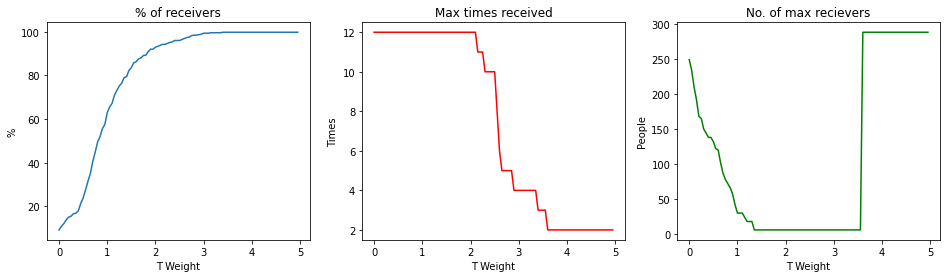

In [6]:
# create a new dataframe for the anlysis
food_df = run_multiple_sims(dataframe, weight=target_weight, package='food', var='T')

# plots the simulation results
plot_sim_results(food_df)

### Optimisation

In [7]:
# finds an optimized weight
optimize_weight(dataframe, var=var, anchors=anchors, iterations=iterations, package='food')

Error rate:

2.454
2.267
2.23
2.158
2.111
2.082
2.062
2.048
2.062
2.072
2.082
1.837
1.597
1.607
1.607
0.617
0.374
0.384
0.136
0.144
0.144
0.146
0.146
0.399
0.399
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389


,best_weight,error_rate,recievers_percent,max_x_recieved,no_max_recievers
18,2.9,0.136329,98.669623,4,6


## Hygiene package

These cells show what would happen if 150 hygeine packages were distributed each month on 50% of the data (only women will recieve this package) and how tuning the allgorithm's weight(s) can help to achieve the desired distribution. 

### Simulation

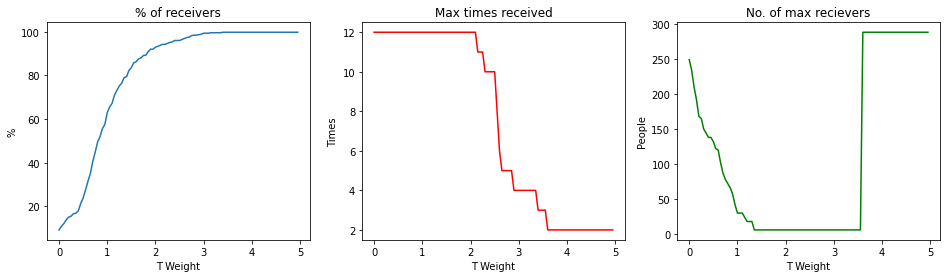

In [8]:
# create a new dataframe for the anlysis
hygeine_df = run_multiple_sims(dataframe, weight=target_weight, package='hygeine', var='T')

# plots the simulation results
plot_sim_results(hygeine_df)

### Optimisation

In [9]:
# finds an optimized weight
optimize_weight(dataframe, var=var, anchors=anchors, iterations=iterations, package='hygeine')

Error rate:

2.454
2.267
2.23
2.158
2.111
2.082
2.062
2.048
2.062
2.072
2.082
1.837
1.597
1.607
1.607
0.617
0.374
0.384
0.136
0.144
0.144
0.146
0.146
0.399
0.399
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389
3.389


,best_weight,error_rate,recievers_percent,max_x_recieved,no_max_recievers
18,2.9,0.136329,98.669623,4,6
